In [1]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import random
import copy
from sklearn.preprocessing import StandardScaler #归一化工具
import math
from math import e

#近海富营养化关键要素：溶解无机氮（DIN）、溶解无机磷（DIP）、溶解硅酸盐（DSi）、化学需氧量（COD）

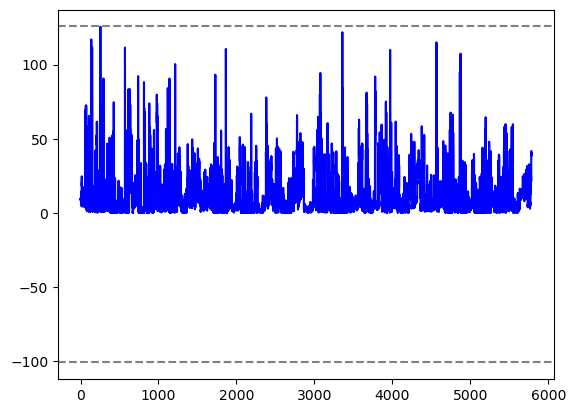

In [2]:
#数据预处理与数据集拆分
data = pd.read_excel("D:/data2015-2018浙江省实测富营养化参数数据.xlsx", sheet_name = 0)
data = data[['lon','lat','水深','溶解氧','盐度','磷酸盐','WJN','COD']]
data['富营养化指数']=list(map(lambda COD,DIN,DIP: COD*DIN*DIP*1000.0/4.5, data['COD'], data['WJN'],data['磷酸盐']))
#data.info(null_counts= True) #没有null数据，但是有值为负数的错误数据
data_positive = data[data.select_dtypes(include=[np.number]).ge(0).all(1)] #删除所有带负值的行
#data_positive.info(null_counts= True)

# def getRandomIndex(n, x):
# 	# 索引范围为[0, n), 随机选x个不重复
#     index = random.sample(range(n), x)
#     return index
# train_index = np.array(getRandomIndex(data_positive.shape[0], int(data_positive.shape[0]*0.9)))
# test_index = np.delete(np.arange(data_positive.shape[0]), train_index)
# train = data_positive.iloc[train_index]
# test = data_positive.iloc[test_index]

#去除正态分布5个标准差以外的数据
abnormal_up = data_positive['富营养化指数'].mean() + 5* data_positive['富营养化指数'].std()
abnormal_low = data_positive['富营养化指数'].mean() - 5* data_positive['富营养化指数'].std()
plt.axhline(y = abnormal_up, linestyle = '--', color = 'gray')
plt.axhline(y = abnormal_low, linestyle = '--', color = 'gray')

data_positive = data_positive[data_positive['富营养化指数']<abnormal_up]
plt.plot(list(range(0,data_positive['富营养化指数'].size)), data_positive['富营养化指数'], color = 'blue')

In [23]:
#80%为训练集，10%为验证集，10%为测试集
train = data_positive[0:int(data_positive.shape[0]*0.8)]
test = data_positive[int(data_positive.shape[0]*0.8)+1:int(data_positive.shape[0]*0.9)]
valid = data_positive[int(data_positive.shape[0]*0.9)+1:]

x_train1 = train[['WJN','磷酸盐','COD']].to_numpy()
y_train1 = np.array(train['富营养化指数'])
x_test1 = test[['WJN','磷酸盐','COD']].to_numpy()
y_test1 = np.array(test['富营养化指数'])
x_valid1 = valid[['WJN','磷酸盐','COD']].to_numpy()
y_valid1 = np.array(valid['富营养化指数'])

x_train2 = train[['盐度','水深','溶解氧']].to_numpy()
y_train2 = np.array(train['富营养化指数'])
x_test2 = test[['盐度','水深','溶解氧']].to_numpy()
y_test2 = np.array(test['富营养化指数'])
x_valid2 = valid[['盐度','水深','溶解氧']].to_numpy()
y_valid2 = np.array(valid['富营养化指数'])

x_train3 = train[['lat','lon','盐度']].to_numpy()
y_train3 = np.array(train['富营养化指数'])
x_test3 = test[['lat','lon','盐度']].to_numpy()
y_test3 = np.array(test['富营养化指数'])
x_valid3 = valid[['lat','lon','盐度']].to_numpy()
y_valid3 = np.array(valid['富营养化指数'])

In [24]:
k = 0
#设置适应度，这里设置为R2
def msefunc(predictval,realval):
    global k
    score = r2_score(realval,predictval)
    print("R^2 = ",score) # R2
    return math.pow(e,score*10.0)
 #设置优化函数，这里为SVR，参数在此绑定，使用验证集输入验证得出适应度
def SVMResult(var):
    global k
    global train_random
    #全集指导
    # train_random = train[['水深','溶解氧','盐度','富营养化指数']].to_numpy().tolist()
    #每一代只使用训练数据的一个子集来指导进化，并（随机）每一代都改变这个子集
    if(k % 20 == 0):
        train_random = random.sample(train[['盐度','水深','溶解氧','富营养化指数']].to_numpy().tolist(),int(train.shape[0]/10))
    #子集与全集交叉指导
    # if (k % 60 == 0 and k > 0):
    #     train_random = train[['水深','溶解氧','盐度','富营养化指数']].to_numpy().tolist()
    print(k,len(train_random),end=' ')
    k = k + 1
    x = list()
    for i in range(0,len(train_random)):
        x.append(train_random[i][0:3])
    y = list()
    for i in range(0,len(train_random)):
        y.append(train_random[i][-1])
    c=var[0]
    e=var[1]
    g=var[2]
    clf = SVR(kernel ='rbf',tol = 0.001,C=c,epsilon=e,gamma=g)
    clf.fit(x, y)
    predictval=clf.predict(x_test2)
    return msefunc(predictval,y_test2)
class GAIndividual:
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.
 
    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
 
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = SVMResult(self.chrom)
        
 
class GeneticAlgorithm:
 
    '''
    The class for genetic algorithm
    '''
 
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop人口规模
        vardim: dimension of variables变量维数
        bound: boundaries of variables变量边界
        MAXGEN: termination condition终止条件
        param: algorithm required parameters, it is a list which is consisting of crossover rate, mutation rate, alpha
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 3))
        self.params = params
 
    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)
 
    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness
 
    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.maxfitness = np.max(self.fitness)
        
        self.trace[self.t, 0] =  self.best.fitness
        self.trace[self.t, 1] =  self.avefitness
        self.trace[self.t, 2] =  self.maxfitness
        print("Generation %d: optimal function value is: %f; average function value is %f;max function value is %f"% (
            self.t, math.log(self.trace[self.t, 0],e)/10.0, math.log(self.trace[self.t, 1],e)/10.0,math.log(self.trace[self.t, 2],e)/10.0))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
            self.maxfitness = np.max(self.fitness)
            
            self.trace[self.t, 0] =  self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            self.trace[self.t, 2] =  self.maxfitness
            print("Generation %d: optimal function value is: %f; average function value is %f;max function value is %f"% (
            self.t, math.log(self.trace[self.t, 0],e)/10.0, math.log(self.trace[self.t, 1],e)/10.0,math.log(self.trace[self.t, 2],e)/10.0))
 
        print("Optimal function value is: %f; " % (math.log(self.trace[self.t, 0],e)/10.0))
        print ("Optimal solution is: %f %f %f" %(self.best.chrom[0],self.best.chrom[1],self.best.chrom[2]))
        #print (self.best.chrom)
        self.printResult()
 
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))
 
        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]
 
        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop
 
    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop
 
    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop
 
    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = np.log(self.trace[:, 0]) / np.log(e) /10
        y2 = np.log(self.trace[:, 1]) / np.log(e) /10
        y3 = np.log(self.trace[:, 2]) / np.log(e) /10
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.plot(x, y3, 'b', label='max value')
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.xlabel("GENS")
        plt.ylabel("R^2")
        plt.title("GA")
        plt.legend()
        plt.show()       


0 462 R^2 =  -11.82794737569979
1 462 R^2 =  -11.82794737569979
2 462 R^2 =  -11.82794737569979
3 462 R^2 =  -6.292096266087823
4 462 R^2 =  -11.82794737569979
5 462 R^2 =  0.2170497221575164
6 462 R^2 =  -9.261152272484232
7 462 R^2 =  -11.82794737569979
8 462 R^2 =  -11.82794737569979
9 462 R^2 =  -11.827947375699795
10 462 R^2 =  -11.82794737569979
11 462 R^2 =  -11.82794737569979
12 462 R^2 =  -11.82794737569979
13 462 R^2 =  -11.82794737569979
14 462 R^2 =  -11.82794737569979
15 462 R^2 =  -11.82794737569979
16 462 R^2 =  -11.82794737569979
17 462 R^2 =  -0.5071823972067038
18 462 R^2 =  -7.534185550234113
19 462 R^2 =  -1.755062201840627
Generation 0: optimal function value is: 0.217050; average function value is -0.082452;max function value is 0.217050
20 462 R^2 =  -0.03604216162681051
21 462 R^2 =  -0.03604216162681051
22 462 R^2 =  -0.03604216162681051
23 462 R^2 =  -11.830359329587422
24 462 R^2 =  -0.03604216162681051
25 462 R^2 =  -0.03604216162681051
26 462 R^2 =  -0.0360

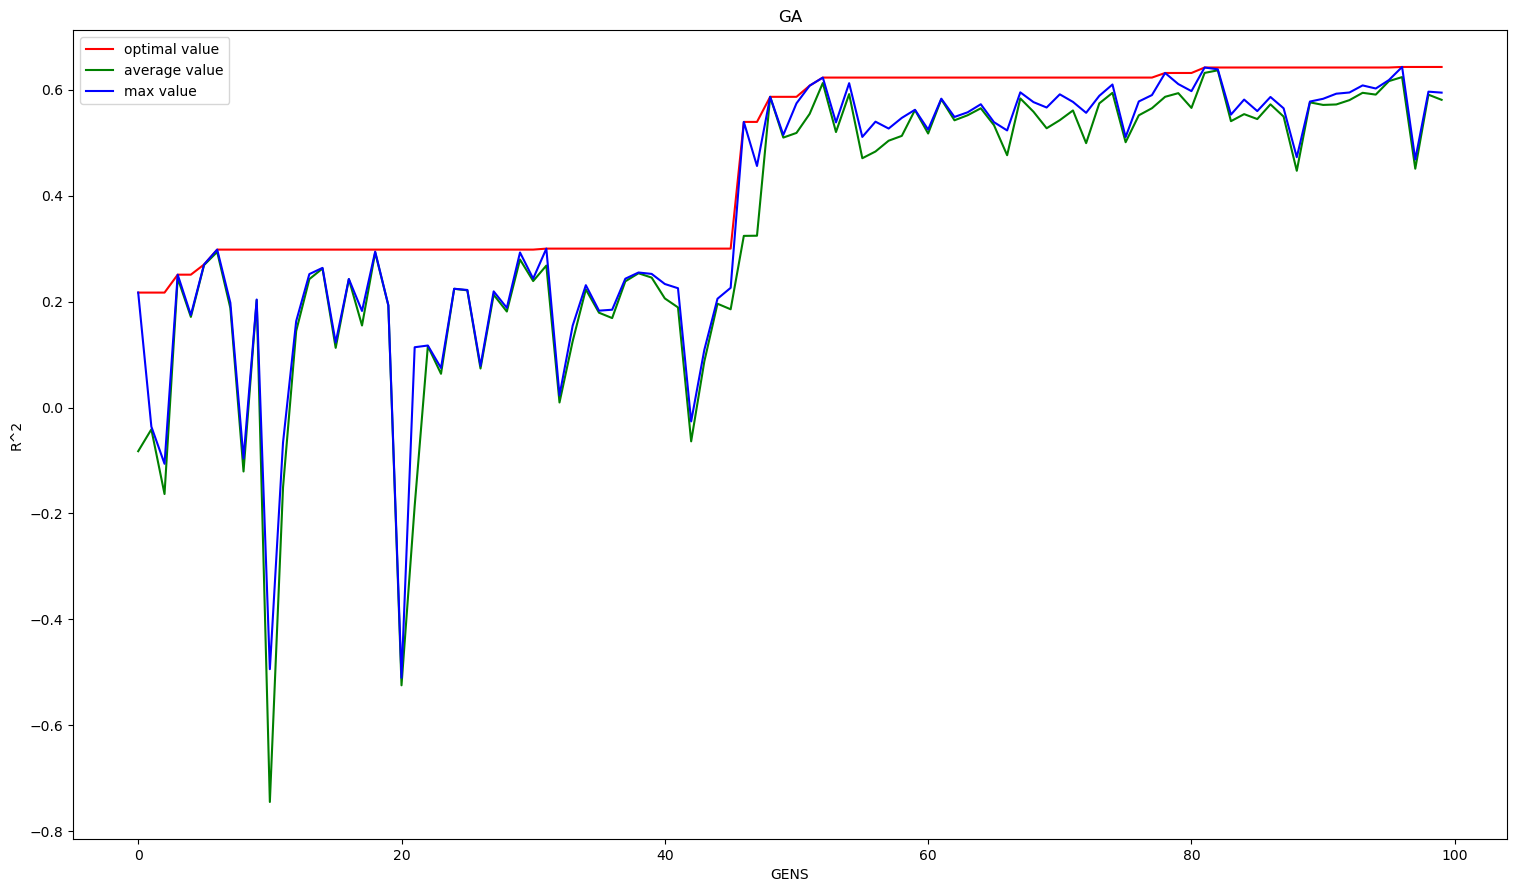

In [26]:
k=0
if __name__ == "__main__":
   bound = np.array([[0,0,0],[100000,150,1]]) #C、epsilon、gamma
   ga = GeneticAlgorithm(20, 3, bound, 100, [0.9, 0.1, 0.5]) # popsize, 变量维数, 参数边界, 遗传代数, [交叉率、突变率、α]
   ga.solve()

In [207]:
# R方转换为指数函数，消除适应度负值
# Optimal function value is: 0.134805; 
# Optimal solution is: 11700.690145 64.368385 0.045611

# 增大正R方的适应度，减少负R方的适应度之后：（训练集随机子集）
# Optimal function value is: 0.384680; 
# Optimal solution is: 19885.118533 102.952927 0.133585
# Optimal function value is: 0.360359; 
# Optimal solution is: 57068.453882 60.462872 0.009489

#采用训练集全集：
# Optimal function value is: 0.419362; 
# Optimal solution is: 92254.693610 95.897222 0.031761

#全集子集交叉指导：
# Optimal function value is: 0.372204; 
# Optimal solution is: 3200.035517 56.072685 0.127297
# Optimal function value is: 0.410156; 
# Optimal solution is: 33321.380158 111.887258 0.024670


In [8]:
#验证集1
svr = SVR(
    kernel ='rbf',
    tol = 0.001,
    C = 39166.469144,
    epsilon = 0.333448,
    gamma =  0.757189
)
svr.fit(x_train1,y_train1)
y_pred = svr.predict(x_valid1)
print(r2_score(y_valid1,y_pred))

0.999782981333269


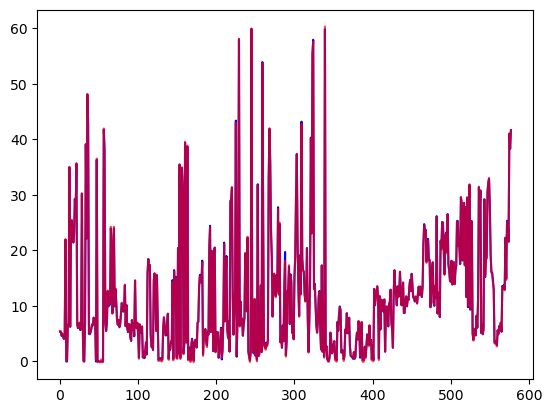

In [9]:
plt.plot(list(range(0,y_valid1.size)), y_valid1, color = 'blue',alpha=1)
plt.plot(list(range(0,y_pred.size)), y_pred, color = 'red',alpha=0.7)
plt.show()

In [11]:
#测试集0.661774
#0.627509
#验证集2
svr = SVR(
    kernel ='rbf',
    tol = 0.001,
    C = 176.735880,#839.531281,
    epsilon = 2.476691,#2.894150,
    gamma = 0.059890#0.006854,
)  
svr.fit(x_train2,y_train2)
y_pred = svr.predict(x_valid2)
print(r2_score(y_valid2,y_pred))

0.3534855046553669


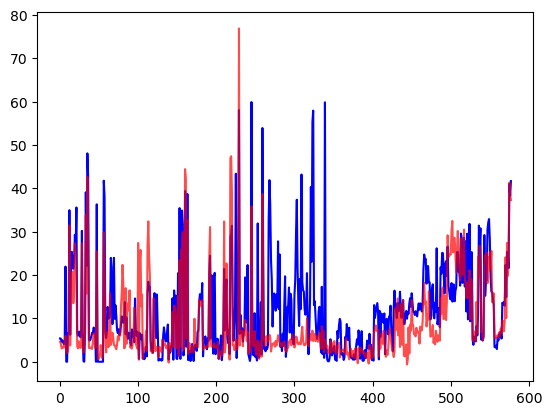

In [12]:
plt.plot(list(range(0,y_valid2.size)), y_valid2, color = 'blue',alpha=1)
plt.plot(list(range(0,y_pred.size)), y_pred, color = 'red',alpha=0.7)
plt.show()

In [18]:
#测试集0.703847
#验证集3
svr = SVR(
    kernel ='rbf',
    tol = 0.001,
    C = 489.727913,#71922.527810,
    epsilon = 1.470550,#3.389627,
    gamma = 0.034341#0.025010
)  
svr.fit(x_train3,y_train3)
y_pred = svr.predict(x_valid3)
print(r2_score(y_valid3,y_pred))

0.4128852709525481


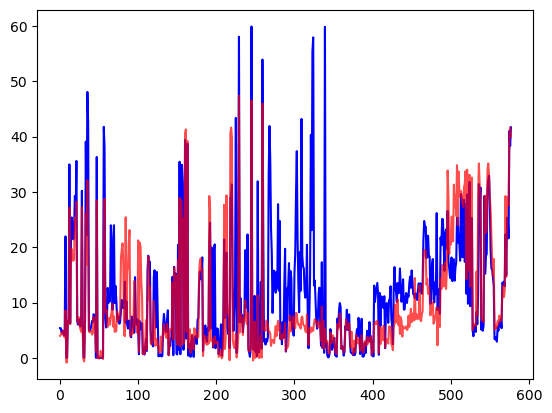

In [19]:
plt.plot(list(range(0,y_valid3.size)), y_valid3, color = 'blue',alpha=1)
plt.plot(list(range(0,y_pred.size)), y_pred, color = 'red',alpha=0.7)
plt.show()